## Data Manipulation and Visualization

Fort this project, I'll analyze the data of Kickstarter, a crowdfunding platform that aims to "help bring creative projects to life". The data was originally from https://www.kaggle.com/datasets/kemical/kickstarter-projects?resource=download.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import holoviews as hv
import hvplot.pandas
import panel as pn
pn.extension()

import warnings
warnings.filterwarnings('ignore')

In [4]:
data_df = pd.read_csv('kickstarter.csv')

### Step 1. Update Format

- Change the format of columns, ``launched`` and ``deadline``, to datetime
- Generate new columns to represent the ``year`` and ``month`` during which the project was ``launched``

In [5]:
data_df['launched'] = pd.to_datetime(data_df['launched'])
data_df['deadline'] = pd.to_datetime(data_df['deadline'])

In [6]:
data_df['year'] = data_df['launched'].dt.year 
data_df['month'] = data_df['launched'].dt.month 

### Step 2. Noisy data
- Identify data with noisy launched time 
- Evaluate whether to fix the noise or remove the noise

In [7]:
data_df.year.unique()

array([2015, 2017, 2013, 2012, 2016, 2014, 2010, 2011, 2009, 1970, 2018],
      dtype=int32)

In [8]:
data_df.groupby('year')['ID'].count()

year
1970        7
2009     1329
2010    10519
2011    26237
2012    41165
2013    44851
2014    67745
2015    77300
2016    57184
2017    52200
2018      124
Name: ID, dtype: int64

In [9]:
# Seems like most of the data are from year 2009~2018, but we do have outliers with year 1970, and we don't have much so I decided to remvoe it.
# I think removing only these 7 records won't have a huge impact for my analysis.
data_df = data_df[data_df['year'] != 1970]

In [24]:
# Check for duplicate IDs in the data_df
duplicate_ids = data_df[data_df.duplicated(subset='ID', keep=False)]

# Print the number of duplicates and display them
print(f"Number of duplicate IDs: {len(duplicate_ids)}")
print(duplicate_ids)

Number of duplicate IDs: 0
Empty DataFrame
Columns: [ID, name, category, main_category, country, currency, launched, deadline, goal, pledged, state, backers, usd_pledged_real, usd_goal_real, year, month]
Index: []


### Step 3. Success rate

- Create a figure with two subplots (one column two rows) sharing
- Subplot 1: Use line chart to visualize the average success rate of projects (i.e., annual success rate) across years until 2017 (in other words, x-axis: year, y-axis: success rate) 
- Subplot 2: Use a bar plot to display the number of projects per year (until 2017) 

In [11]:
test = data_df[['ID', 'year', 'state']]
test = test[test['year'] < 2018]
success = test[test['state'] == 'successful'].groupby('year')['ID'].count()
total = test.groupby('year')['ID'].count()
#success_rate = (success / total).fillna(0)
success_rate = (success.reindex(total.index) / total).fillna(0)
final_df = pd.DataFrame({'year': success_rate.index, 'successrate':success_rate.values, 'total_ids': total.loc[success_rate.index].values})
print(final_df)

   year  successrate  total_ids
0  2009     0.435666       1329
1  2010     0.436638      10519
2  2011     0.463887      26237
3  2012     0.434641      41165
4  2013     0.432878      44851
5  2014     0.311565      67745
6  2015     0.271294      77300
7  2016     0.328169      57184
8  2017     0.353678      52200


<Axes: xlabel='year', ylabel='successrate'>

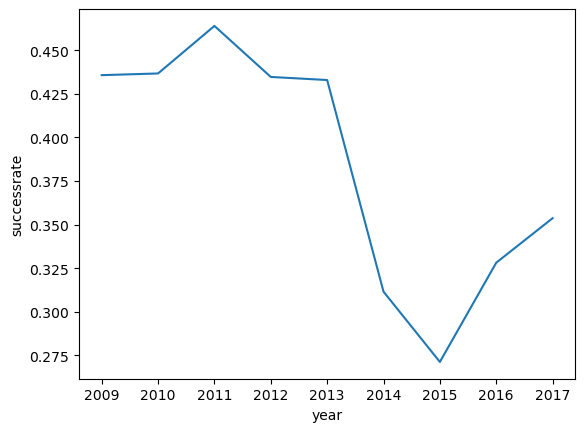

In [12]:
sns.lineplot(data = final_df, x = 'year', y = 'successrate')

<Axes: xlabel='year', ylabel='total_ids'>

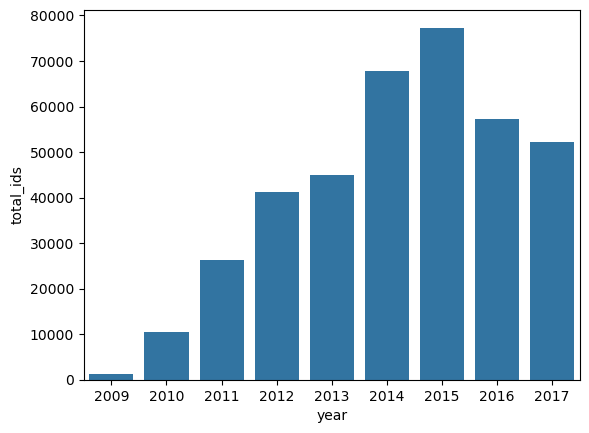

In [13]:
sns.barplot(data = final_df, x = 'year', y = 'total_ids')

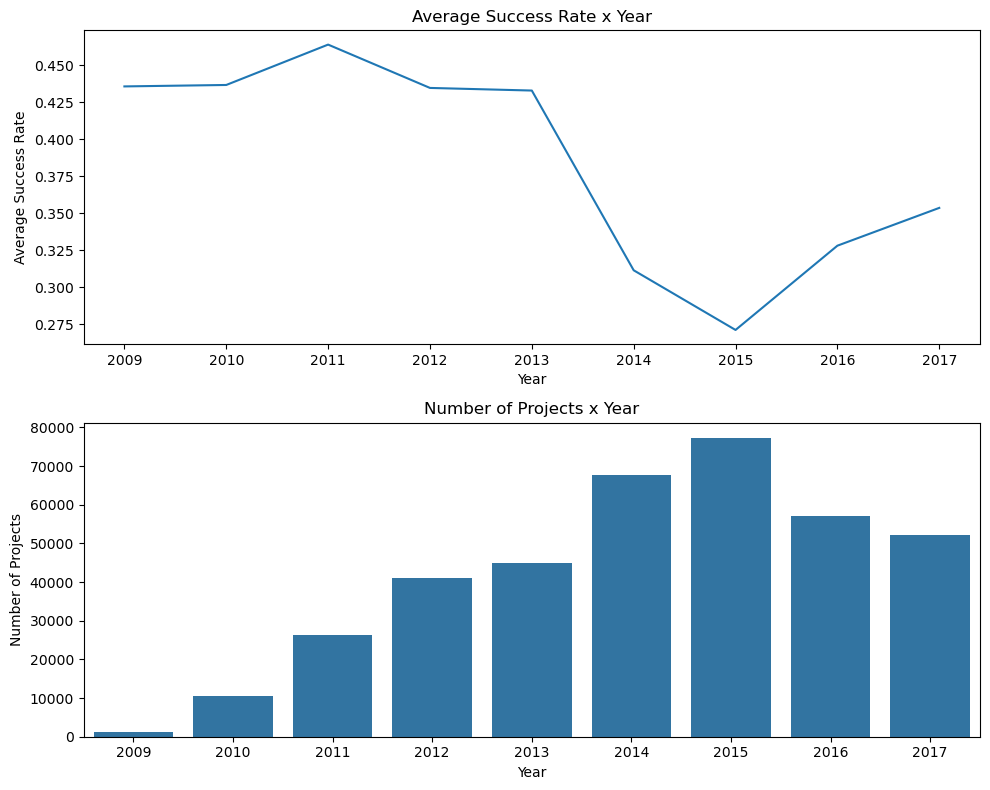

In [14]:
f, ax = plt.subplots(2, 1, figsize = (10,8))
sns.lineplot(data = final_df, x = 'year', y = 'successrate', ax = ax[0])
ax[0].set_title('Average Success Rate x Year')
ax[0].set_ylabel('Average Success Rate')

sns.barplot(data = final_df, x = 'year', y = 'total_ids', ax = ax[1])
ax[1].set_title('Number of Projects x Year')
ax[1].set_ylabel('Number of Projects')

ax[0].set_xlabel('Year')
ax[1].set_xlabel('Year')

plt.tight_layout()
plt.show()

### Step 4. Hypothesis and exploration

A hypothesis I have is that the nature of different project categories might play a role here. Maybe in some years, we only focused on certain high success rate categories. For example, success rate dropped in year 2015, while we have the most projects in 2015. If we had significantly more low success rate project in year 2015, it might skew the results.

To do that, I have to first find out the project category with the worst success rate. Next, I can look into a bar chart and see how many of this low performing project category do we have for each year. If we have an abnormal increase of this category in 2015, it might be the main reason why the success rate dropped.

In [25]:
test3 = data_df[['ID', 'category', 'year', 'state']]
test3 = test3[test3['year'] < 2018]
success = test3[test3['state'] == 'successful'].groupby('category')['ID'].count()
total = test3.groupby('category')['ID'].count()
success_rate = (success / total).fillna(0)
final_df2 = pd.DataFrame({'category': success_rate.index, 'successrate':success_rate.values, 'total_ids': total.loc[success_rate.index].values})
print(final_df2.sort_values(by = 'successrate', ascending = True).head(1))

  category  successrate  total_ids
8     Apps     0.059621       6340


<Axes: xlabel='year', ylabel='ID'>

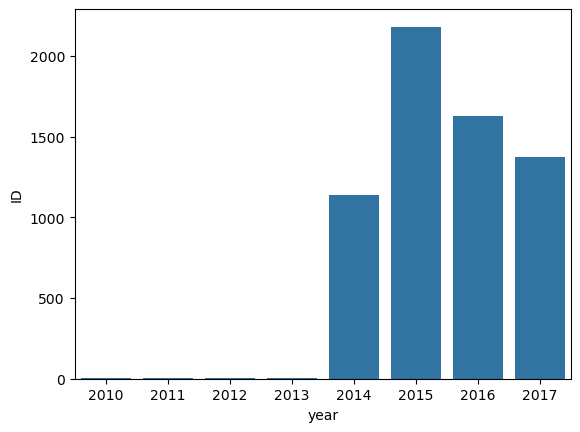

In [16]:
# Since Apps is the worse performing category, I'll filter it out and see the distribution of Apps Projects
test4 = data_df[['ID', 'category', 'year']]
test4 = test4[test4['year'] < 2018]
test4 = test4[test4['category'] == 'Apps']
test4.drop('category', axis=1, inplace=True)
sns.barplot(test4.groupby('year')['ID'].count())

In [17]:
# Recall the line graph, success rate roughly dropped from year 2013, and most drastically during 2015. 
# This seems to align with the trend I discovered, since we only started to introduce more Apps projects starting from year 2014.
# Additionally, we introduced the most amount of Apps projects in 2015. The increase of thess low performing projects might be the reason why success rate drops.

### Step 5. Dashboard

For practice, I'll build an interactive dashboard following the requirements below:
1. Choose from one of the three countries: US, France (FR), United Kingdom of Great Britain and Northern Ireland (GB)
2. Has a slider to choose the year of the visualization
3. Visualize either the number of projects or the number of success projects (as y-axis) 
4. Has a line chart to visualize the y-axis across months of the year

In [18]:
idf = data_df.interactive()
# country
country = pn.widgets.RadioButtonGroup(
    name='country', 
    options = ['US', 'FR', 'GB'],
    button_type = 'success')
country

RadioButtonGroup(button_type='success', name='country', options=['US', 'FR', 'GB'], value='US')

In [19]:
# slider
year = pn.widgets.IntSlider(name='year', start=2009, end=2017, step=1)
year

IntSlider(end=2017, name='year', start=2009, value=2009)

In [20]:
# yaxis
yaxis = pn.widgets.RadioButtonGroup(
    name='Y-Axis', 
    options = ['Number of Projects', 'Number of Successful Projects'],
    button_type = 'success')
yaxis

RadioButtonGroup(button_type='success', name='Y-Axis', options=['Number of Projects', ...], value='Number of Projects')

In [21]:
def filter_data(country, year, yaxis):
    ipipeline = data_df[(data_df['country'] == country) & (data_df['year'] == year)]
    
    if yaxis == 'Number of Successful Projects':
        ipipeline = ipipeline[ipipeline['state'] == 'successful']
    
    project_count = ipipeline.groupby('month').size().reset_index(name='project_count')
    
    return project_count

In [22]:
def plot_data(country, year, yaxis):
    project_count = filter_data(country, year, yaxis)
    
    return project_count.hvplot.line(
        x='month', 
        y='project_count', 
        xlabel='Month', 
        ylabel='Projects', 
        line_width=2
    )

In [23]:
@pn.depends(country, year, yaxis) 
def update_plot(country, year, yaxis):
    return plot_data(country, year, yaxis)

dashboard = pn.Column(
    pn.Row(country, year, yaxis),  # First row with widgets
    update_plot  # Bind plot to the widget updates
)

dashboard.servable()

Column
    [0] Row
        [0] RadioButtonGroup(button_type='success', name='country', options=['US', 'FR', 'GB'], value='US')
        [1] IntSlider(end=2017, name='year', start=2009, value=2009)
        [2] RadioButtonGroup(button_type='success', name='Y-Axis', options=['Number of Projects', ...], value='Number of Projects')
    [1] ParamFunction(function, _pane=HoloViews, defer_load=False)